In [1]:
# Importing librairies

from jiwer import wer, cer, mer, wip, wil
import re
import csv
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import string
import operator

#from sentence_transformers import SentenceTransformer, util
#model = SentenceTransformer('all-MiniLM-L6-v2')

In [2]:
def get_dataset(data):
    """Gets and returns filename and sentences from a dataset.
    
    Parameters
    ----------
        data : str
        Path to csv file.
        
    Returns
    -------
        dict_values : dict
        Audio filename as key and its written transcription as value.
    """
    dict_values = {}
    
    with open(data, newline='') as f:
        reader = csv.reader(f, delimiter=' ', quotechar='|')
        for row in reader:
            row = ' '.join(row).split('\t')
            dict_values[row[0]] = row[1].lower()
            
        f.close()
    
    return dict_values

In [3]:
truth = get_dataset("../ground_truth/truth_train.csv")
performed = get_dataset("output_performed_wav2vec2/w2v_performed_train.csv")
performed_improved = get_dataset("output_performed_wav2vec2/w2v_performed_small_lm.csv")
performed_live = get_dataset("output_performed_wav2vec2/w2v_performed_live.csv")

In [4]:
def asr_evaluation(truth, performed, txt):
    
    ground_truths = list(truth.values())
    hypothesis = list(performed.values())
    
    print("Model",txt,":\n")
    
    wer_score = wer(truth=ground_truths, hypothesis=hypothesis)
    print(f"Word Error Rate (WER) = {wer_score}")

    cer_score = cer(truth=ground_truths, hypothesis=hypothesis)
    print(f"Character Error Rate (CER) = {cer_score}")
    
    mer_score = mer(truth=ground_truths, hypothesis=hypothesis)
    print(f"Match Error Rate (MER) = {mer_score}")
    
    wip_score = wip(truth=ground_truths, hypothesis=hypothesis)
    print(f"Word Information Preserved (WIP) = {wip_score}")

In [5]:
asr_evaluation(truth,performed,"\n\nWav2Vec2 1b with LM")

Model 

Wav2Vec2 1b with LM :

Word Error Rate (WER) = 0.13752250040909836
Character Error Rate (CER) = 0.023215803056330878
Match Error Rate (MER) = 0.13543479662218785
Word Information Preserved (WIP) = 0.7791868087568564


In [6]:
asr_evaluation(truth,performed_improved,"\n\nWav2Vec2 300m with small LM")

Model 

Wav2Vec2 300m with small LM :

Word Error Rate (WER) = 0.05691376206840124
Character Error Rate (CER) = 0.011090971749064133
Match Error Rate (MER) = 0.05651425043060024
Word Information Preserved (WIP) = 0.9015561407465607


In [7]:
asr_evaluation(truth,performed_live,"\n\nWav2Vec2 300m with small LM(compressed Linear)")

Model 

Wav2Vec2 300m with small LM(compressed Linear) :

Word Error Rate (WER) = 0.05663557519227622
Character Error Rate (CER) = 0.01101731254389957
Match Error Rate (MER) = 0.05622339907079502
Word Information Preserved (WIP) = 0.9021389415483403


In [8]:
def get_info_dataset(data, name):
    """Gets and returns filename and sentences from a dataset.
    
    Parameters
    ----------
        data : str
        Path to tsv file.
        
        name : str
        Name for output file.
        
    
    Produces
    -------
        csv file
        List of audio filenames and their translation.
        
    Returns
    -------
        list_data : list
        List of filenames belonging to the train, test or validation dataset.
        
        gold_values : dict
        Audio filename as key and its written transcription as value.
    """

    tsv_data = pd.read_csv(data, sep='\t')
    gold_values = {}

    for i, path_file in enumerate(tsv_data['path']):
        up_votes = tsv_data['up_votes'][i]
        down_votes = tsv_data['down_votes'][i]
        age = tsv_data['age'][i]
        gender = tsv_data['gender'][i]
        locale = tsv_data['locale'][i]
        segment = tsv_data['segment'][i]
        
        gold_values[path_file] = [up_votes,down_votes,age,gender,locale,segment]
    
    with open(name, 'w') as f:
        for key in gold_values.keys():
            f.write("%s\t%s\n"%(key,gold_values[key]))
    
    return gold_values

In [11]:
truth_train_info = get_info_dataset('../dataset_translations/train.tsv', '../ground_truth/info_truth_train.csv')

In [12]:
def get_errors(truth,performed):
    wrong = {}
    correct = {}
    wrong_space = {}
    diff_word = {}
    only_one_error = {}
    position_error = {}
    age = []
    gender = []
    up_votes = []
    down_votes = []

    age_t = []
    gender_t = []
    up_votes_t = []
    down_votes_t = []

    for key in truth.keys():
        info = truth_train_info[key]
        up_votes_t.append(info[0])
        down_votes_t.append(info[1])
        age_t.append(info[2])
        gender_t.append(info[3])

        if truth[key].split() == performed[key].split():
            correct[truth[key]] = performed[key]
        else:
            up_votes.append(info[0])
            down_votes.append(info[1])
            age.append(info[2])
            gender.append(info[3])

            # It often occurs that two sentences are matching
            # but spaces are at different positions:
            # тис великий князь витичівський | ти с великий князь витичівський 
            t_space = truth[key].replace(" ", "")
            p_space = performed[key].replace(" ", "")

            if t_space == p_space:
                wrong_space[truth[key]] = performed[key]
            else:
                t_word = truth[key].split()
                p_word = performed[key].split()

                errors_count = 0
                errors_in_position = 0
                w1_err = ""
                w2_err = ""

                for count, (w1,w2) in enumerate(zip(t_word,p_word)):                        

                    if w1 != w2:
                        errors_count += 1
                        w1_err = w1
                        w2_err = w2

                        if count > 0:
                            if count < len(p_word)-1:
                                if (p_word[count-1] == t_word[count]) or (p_word[count+1] == t_word[count]):
                                    errors_in_position += 1
                            else:
                                if p_word[count-1] == t_word[count]:
                                    errors_in_position += 1

                        diff_word[w1] = w2

                # It often occurs that only one word is mislabeled in a sentence    
                if errors_count == 1:
                    only_one_error[w1_err] = w2_err
                # Sometimes, because of an added word or letter in a sentence
                # it shiftes all words from 1 position and then when we
                # compare it, it is considered as wrong
                elif errors_in_position >= len(truth)%2:
                    position_error[truth[key]] = performed[key]
                else:
                    wrong[truth[key]] = performed[key]
                    #print(truth[key],"|",performed[key],"\n")
    
    print("Matching translations:",len(correct)/len(truth)*100,"%\nWrong translations because of split words:",len(wrong_space)/len(truth)*100,"%\nWrong translations that are being reviewed:",len(wrong)/len(truth)*100,"%\nOnly one wrong word in sentence:",len(only_one_error)/len(truth)*100,"%\nPositional error in sentence:",len(position_error)/len(truth)*100,"%\n(For example if a word is split into two words, it will lead to a positional error in sentence.)\n")
    
    return wrong, wrong_space, diff_word, only_one_error, position_error, [age,gender,up_votes,down_votes], [age_t,gender_t,up_votes_t,down_votes_t]

In [13]:
print("* Wav2Vec 2.0 1b with LM:\n")
w1, ws1, dw1, ooe1, pe1, stats1, t_stats = get_errors(truth,performed)

* Wav2Vec 2.0 1b with LM:

Matching translations: 56.04038137969714 %
Wrong translations because of split words: 9.23163208076276 %
Wrong translations that are being reviewed: 9.108244531688166 %
Only one wrong word in sentence: 14.985978687605158 %
Positional error in sentence: 9.07459338194055 %
(For example if a word is split into two words, it will lead to a positional error in sentence.)



In [14]:
print("* Wav2Vec 2.0 300m with small LM:\n")
w2, ws2, dw2, ooe2, pe2, stats2, t_stats = get_errors(truth,performed_improved)

* Wav2Vec 2.0 300m with small LM:

Matching translations: 77.75659001682558 %
Wrong translations because of split words: 1.79472798653954 %
Wrong translations that are being reviewed: 3.9484015703869884 %
Only one wrong word in sentence: 10.061693774537297 %
Positional error in sentence: 4.004486819966349 %
(For example if a word is split into two words, it will lead to a positional error in sentence.)



In [15]:
print("* Wav2Vec 2.0 300m with small LM(compressed):\n")
w3, ws3, dw3, ooe3, pe3, stats3, t_stats = get_errors(truth,performed_live)

* Wav2Vec 2.0 300m with small LM(compressed):

Matching translations: 78.03701626472238 %
Wrong translations because of split words: 1.682557487380819 %
Wrong translations that are being reviewed: 3.9484015703869884 %
Only one wrong word in sentence: 9.904655075715088 %
Positional error in sentence: 3.9035333707235 %
(For example if a word is split into two words, it will lead to a positional error in sentence.)



In [16]:
import difflib
#https://stackoverflow.com/questions/17904097/python-difference-between-two-strings

def tell_diff(data_t,data_p):
    
    for key in data_t.keys():
        if data_t[key] != data_p[key]:
            cases.append([data_t[key],data_p[key]])
    
    for a,b in cases:     
        print('{} => {}'.format(a,b))  
        for i,s in enumerate(difflib.ndiff(a, b)):
            if s[0]==' ': continue
            elif s[0]=='-':
                print(u'Delete "{}" from position {}'.format(s[-1],i))
            elif s[0]=='+':
                print(u'Add "{}" to position {}'.format(s[-1],i))    
        print()
        
#tell_diff(truth,performed_live)

In [17]:
def understanding_only_one_error(data_result):
    
    count_len = 0
    count_let = 0
    count_len_missing = 0
    count_len_added = 0
    diff_letter = {}
    diff_words = {}
    
    for truth, performed in data_result.items():
        
        if len(truth) != len(performed):
            count_len += 1
            if len(truth) > len(performed):
                count_len_missing += 1
                if performed in truth:
                    #print(performed,truth)
                    w = re.sub(performed,len(performed)*"_",truth)
                    #print(w)
                    #if letter is doubled
                    
                else:
                    pass
                    #print("%%%%%")
            else:
                count_len_added += 1
        else:
            count_let += 1
            for letters in zip(truth, performed):
                if letters[0] != letters[1]:
                    
                    if letters[0]+"/"+letters[1] in diff_letter:
                        diff_letter[letters[0]+"/"+letters[1]] += 1
                    elif letters[1]+"/"+letters[0] in diff_letter:
                        diff_letter[letters[1]+"/"+letters[0]] += 1
                    else:
                        diff_letter[letters[0]+"/"+letters[1]] = 1
                        
                    if letters[0]+"/"+letters[1] in diff_words:
                        diff_words[letters[0]+"/"+letters[1]] += [[truth,performed]]
                    elif letters[1]+"/"+letters[0] in diff_letter:
                        diff_words[letters[1]+"/"+letters[0]] += [[truth,performed]]
                    else:
                        diff_words[letters[0]+"/"+letters[1]] = [[truth,performed]]
    
    print("\t",round(count_let/(sum(diff_letter.values())+count_len)*100,2),"% words contain only one mismatching letter.\n")
    print("\tMismaching letters:\n\t",sorted(diff_letter.items(),key=operator.itemgetter(1),reverse=True),"\n")
    #print("\tMismaching words:\n\t",sorted(diff_words.items(),key=operator.itemgetter(1),reverse=True),"\n")
                                                                  
    print("\t",round(count_len/len(data_result.keys())*100,2),"% words contain added or missing letter from original sentence.")
    print("\t\t",round(count_len_missing/count_len*100,2),"% words with missing letters")
    print("\t\t",round(count_len_added/count_len*100,2),"% words with added letters")

In [18]:
print("* Wav2Vec 2.0 1b with LM:\n")
understanding_only_one_error(ooe1)

* Wav2Vec 2.0 1b with LM:

	 53.81 % words contain only one mismatching letter.

	Mismaching letters:
	 [('о/у', 105), ('и/е', 91), ('о/а', 72), ('и/і', 50), ('i/і', 48), ('а/е', 47), ('и/а', 35), ('я/ь', 28), ('т/д', 24), ('з/с', 18), ('е/о', 17), ('і/е', 16), ('ж/ш', 13), ('й/ї', 13), ('и/о', 12), ('і/ь', 12), ('й/є', 11), ('л/в', 11), ('в/у', 10), ('є/ю', 10), ('я/є', 10), ('х/г', 9), ('и/я', 9), ('ї/ю', 8), ('я/і', 8), ('и/у', 7), ('ц/с', 7), ('б/п', 7), ('і/й', 6), ('ш/ч', 6), ('е/я', 6), ('б/в', 6), ('я/а', 6), ('н/м', 5), ('ґ/г', 4), ('ю/й', 4), ('е/у', 4), ('п/в', 4), ('т/ч', 4), ('р/л', 4), ('т/ц', 4), ('ш/щ', 4), ('р/в', 4), ('ї/є', 3), ('и/й', 3), ('в/г', 3), ('і/о', 3), ('і/в', 3), ('р/о', 3), ('у/а', 3), ('н/л', 3), ('м/в', 3), ('м/б', 3), ('і/ю', 3), ('р/е', 3), ('у/ю', 3), ('і/є', 3), ('в/н', 2), ('є/е', 2), ('д/б', 2), ('л/у', 2), ('г/м', 2), ('д/в', 2), ('ю/ь', 2), ('г/к', 2), ('к/и', 2), ('р/у', 2), ('з/і', 2), ('н/д', 2), ('и/р', 2), ('и/ь', 2), ('щ/ч', 2), ('з/д', 2

In [19]:
print("* Wav2Vec 2.0 300m with small LM:\n")
understanding_only_one_error(ooe2)

* Wav2Vec 2.0 300m with small LM:

	 24.76 % words contain only one mismatching letter.

	Mismaching letters:
	 [('и/е', 29), ('у/о', 27), ('а/о', 23), ('i/і', 21), ('и/а', 14), ('и/і', 13), ('я/ь', 9), ('а/е', 8), ('е/о', 6), ('с/з', 5), ('п/б', 5), ('и/о', 5), ('и/у', 4), ('є/ю', 4), ('і/ь', 4), ('у/а', 4), ('я/а', 3), ('є/і', 3), ('ц/т', 3), ('т/д', 3), ('ш/ж', 3), ('б/в', 3), ('і/е', 2), ('л/г', 2), ('в/о', 2), ('ї/і', 2), ('в/г', 2), ('к/т', 2), ('х/с', 2), ('ї/ю', 2), ('ї/и', 2), ('і/о', 2), ('я/і', 2), ('з/і', 2), ('ж/д', 2), ('ш/щ', 2), ('щ/ч', 2), ('х/г', 2), ('с/і', 2), ('т/с', 2), ('й/ї', 2), ('в/у', 1), ('ю/ь', 1), ('й/і', 1), ('и/н', 1), ('з/н', 1), ('ч/ш', 1), ('т/й', 1), ('н/д', 1), ('б/т', 1), ('м/г', 1), ('т/н', 1), ('ф/в', 1), ('к/д', 1), ('н/м', 1), ('я/е', 1), ('ф/г', 1), ('в/н', 1), ('і/а', 1), ('ю/к', 1), ('в/п', 1), ('р/в', 1), ('м/в', 1), ('у/ю', 1), ('ш/с', 1), ('о/ь', 1), ('є/е', 1), ('р/и', 1), ('ц/и', 1), ('ю/д', 1), ('н/ю', 1), ('л/в', 1), ('й/л', 1), ('к/ь

In [20]:
print("* Wav2Vec 2.0 300m with small LM(compressed):\n")
understanding_only_one_error(ooe3)

* Wav2Vec 2.0 300m with small LM(compressed):

	 24.12 % words contain only one mismatching letter.

	Mismaching letters:
	 [('и/е', 27), ('у/о', 24), ('i/і', 21), ('а/о', 20), ('и/і', 14), ('а/и', 13), ('я/ь', 9), ('а/е', 7), ('с/з', 6), ('е/о', 6), ('и/о', 6), ('і/е', 5), ('и/у', 4), ('п/б', 4), ('а/я', 4), ('д/т', 4), ('у/а', 4), ('в/у', 3), ('в/г', 3), ('є/і', 3), ('ц/т', 3), ('ю/є', 3), ('р/л', 3), ('в/о', 2), ('у/і', 2), ('н/д', 2), ('б/в', 2), ('ї/ю', 2), ('ї/и', 2), ('т/н', 2), ('і/о', 2), ('і/ь', 2), ('з/і', 2), ('ч/т', 2), ('ш/щ', 2), ('щ/ч', 2), ('л/н', 2), ('с/і', 2), ('т/с', 2), ('й/ї', 2), ('с/ц', 2), ('ю/і', 2), ('и/н', 1), ('ч/ш', 1), ('т/й', 1), ('і/а', 1), ('ї/і', 1), ('к/т', 1), ('ї/є', 1), ('м/г', 1), ('ф/в', 1), ('ш/ж', 1), ('я/і', 1), ('к/д', 1), ('н/м', 1), ('ф/г', 1), ('в/н', 1), ('а/й', 1), ('ю/к', 1), ('я/и', 1), ('в/п', 1), ('р/в', 1), ('ш/с', 1), ('і/м', 1), ('м/е', 1), ('е/н', 1), ('м/в', 1), ('у/ю', 1), ('о/ь', 1), ('є/е', 1), ('р/и', 1), ('ц/и', 1), ('ю/д

In [21]:
def show_scores(labels, title, data_errors, data_total, up):

    if up == True:
        up_val = dict(Counter(data_errors))
        up_val['4'] = 0
        errors_means = list(up_val.values())
    else:
        errors_means = list(dict(Counter(data_errors)).values())
    
    sum_errors = sum(errors_means)
    new_errors_means = []
    for value in errors_means:
        new_val = round((value / sum_errors) * 100, 1)
        new_errors_means.append(new_val)

    total_means = list(dict(Counter(data_total)).values())
    sum_total = sum(total_means)
    new_total_means = []
    for value in total_means:
        new_val = round((value / sum_total) * 100, 1)
        new_total_means.append(new_val)

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, new_errors_means, width, label='Errors in Wav2Vec transcriptions')
    rects2 = ax.bar(x + width/2, new_total_means, width, label='Dataset transcriptions')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

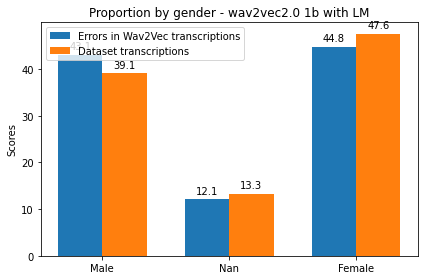

In [22]:
show_scores(['Male', 'Nan', 'Female'],'Proportion by gender - wav2vec2.0 1b with LM',stats1[1],t_stats[1],up = False)

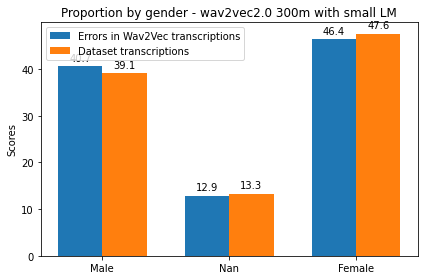

In [23]:
show_scores(['Male', 'Nan', 'Female'],'Proportion by gender - wav2vec2.0 300m with small LM',stats2[1],t_stats[1],up = False)

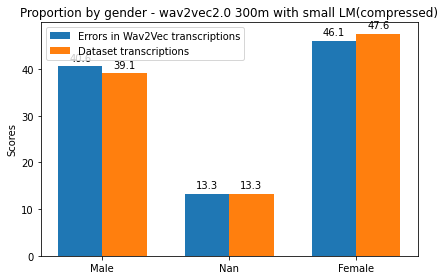

In [24]:
show_scores(['Male', 'Nan', 'Female'],'Proportion by gender - wav2vec2.0 300m with small LM(compressed)',stats3[1],t_stats[1],up = False)

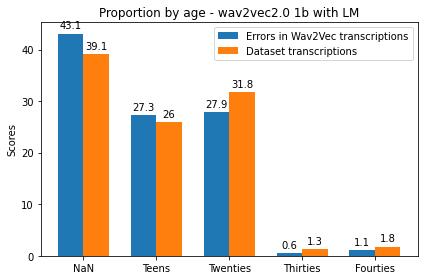

In [25]:
show_scores(['NaN', 'Teens', 'Twenties', 'Thirties', 'Fourties'],'Proportion by age - wav2vec2.0 1b with LM',stats1[0],t_stats[0],up = False)

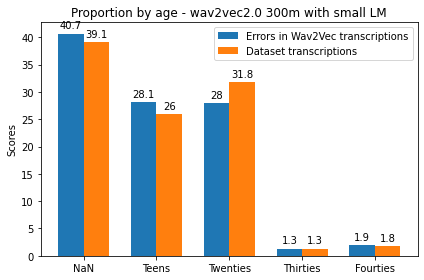

In [26]:
show_scores(['NaN', 'Teens', 'Twenties', 'Thirties', 'Fourties'],'Proportion by age - wav2vec2.0 300m with small LM',stats2[0],t_stats[0],up = False)

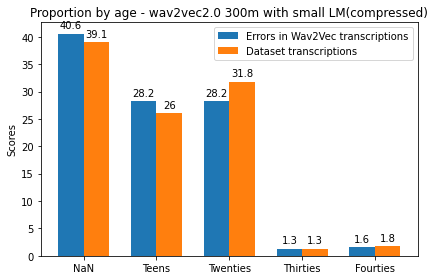

In [27]:
show_scores(['NaN', 'Teens', 'Twenties', 'Thirties', 'Fourties'],'Proportion by age - wav2vec2.0 300m with small LM(compressed)',stats3[0],t_stats[0],up = False)

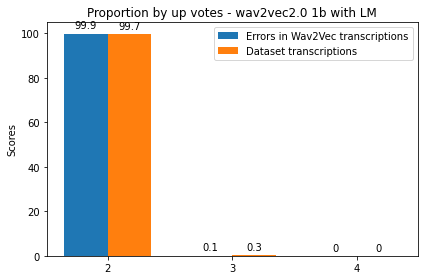

In [28]:
show_scores(['2', '3', '4'],'Proportion by up votes - wav2vec2.0 1b with LM',stats1[2],t_stats[2], up = True)

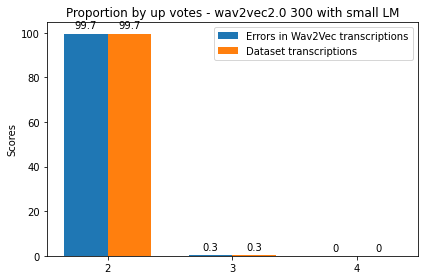

In [29]:
show_scores(['2', '3', '4'],'Proportion by up votes - wav2vec2.0 300 with small LM',stats2[2],t_stats[2], up = True)

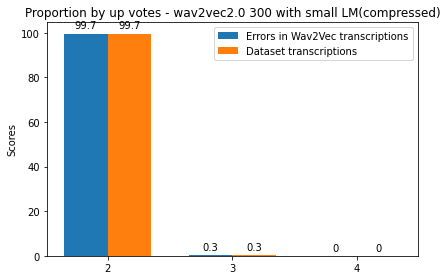

In [30]:
show_scores(['2', '3', '4'],'Proportion by up votes - wav2vec2.0 300 with small LM(compressed)',stats3[2],t_stats[2], up = True)

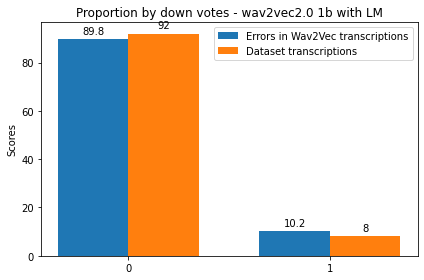

In [31]:
show_scores(['0', '1'],'Proportion by down votes - wav2vec2.0 1b with LM',stats1[3],t_stats[3], up = False)

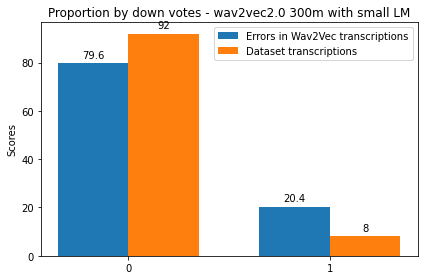

In [32]:
show_scores(['0', '1'],'Proportion by down votes - wav2vec2.0 300m with small LM',stats2[3],t_stats[3], up = False)

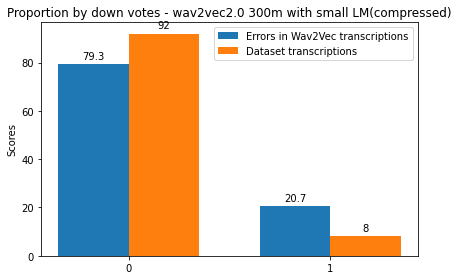

In [33]:
show_scores(['0', '1'],'Proportion by down votes - wav2vec2.0 300m with small LM(compressed)',stats3[3],t_stats[3], up = False)

In [34]:
def create_csv(data_t,data_p,title,title2):#title3
    """Creates csv file of ground truth sentence and performed sentence
    from Wav2Vec2 model.
    
    Parameters
    ----------
        data_t : dict
        Dictionary of wav file (key) and the ground truth sentence (value).
        
        data_p : dict
        Dictionary of wav file (key) and the performed sentence (value).
        
        title : str
        Name for csv file.
        
        title2 : str
        Name for csv file with non matching ground truth and performed output
        only.
    """
    list_values = []
    list_errors = []
    wav_errors = []
    
    for key in data_t.keys():
        list_values.append([data_t[key],data_p[key]])
        if data_t[key] != data_p[key]:
            list_errors.append([data_t[key],data_p[key]])
            #wav_errors.append(key)
    
    
    with open(title, 'w') as f:
        writer = csv.writer(f, delimiter=' ')
        writer.writerows(list_values)
        f.close()
        
    with open(title2, 'w') as f:
        writer = csv.writer(f, delimiter=' ')
        writer.writerows(list_errors)
        f.close()
    
    """
    with open(title3, 'w') as f:
        writer = csv.writer(f, delimiter='\n')
        writer.writerow(wav_errors)
        f.close()
    """
    
    #return wav_errors
        
create_csv(truth,performed_live,"train_truth_performed_live_model.csv","train_truth_performed_live_model_errors_only.csv")#,"../ground_truth/list_train_live_errors_wav.txt")

In [36]:
print(len(list(performed_live.values())[3]))

115


In [37]:
def get_dataset(data, name):
    """Gets and returns filename and sentences from a dataset.
    
    Parameters
    ----------
        data : str
        Path to tsv file.
        
        name : str
        Name for output file.
        
    Returns
    -------
        list_data : list
        List of filenames belonging to the dataset.
        
        gold_values : dict
        Audio filename as key and its written transcription as value.
    """
    
    tsv_data = pd.read_csv(data, sep='\t')
    gold_values = {}
    
    for i, path_file in enumerate(tsv_data['path']):
        sentence = tsv_data['sentence'][i]
        
        #Removes punctuation
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        sentence = re.sub(r"[—–«»…’՚“”]", '', sentence)
        #Should let hyphens and apostrophes in text
        
        #Removes unecessary whitespaces
        sentence = sentence.lower().split()
        
        #We look for a special character that can not be stored in a string
        #(Why? I don't know, it is an accent probably not compatible with
        #other apostrophes. It can not be stored alone by itself, it needs
        #either a space before or a letter to go on. However, I can not
        #remove this accent if there is any other character around, there
        #won't be any match with other words, or otherwise it would probably
        #be over specific and potentially not match other characters that I
        #haven't thought of.)
        # ́
        
        for count, word in enumerate(sentence):
            if word.isalpha() == False:
                for letter in word:
                    if letter.isalpha() == False:
                        word = re.sub(letter, '', word)
                        sentence[count] = word
        
        sentence = " ".join(sentence)
        gold_values[path_file] = sentence
        
    list_data = list(gold_values.keys())[707:]

    with open(name, 'w') as f:
        for key in gold_values.keys():
            f.write("%s\t%s\n"%(key,gold_values[key]))
    
    return list_data, gold_values

In [ ]:
train_data, truth_train = get_dataset('../dataset_translations/train.tsv', '../ground_truth/truth_train.csv')